# Double integrator

For this example we demonstrate learning control for a double integrator system. In this case we learn the control from directly interacting with the system in a typical RL scenario. 

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

We need to install a more recent version of matplotlib than is offered in the default Colab environment. After running the cell 1 for the first time in a new Colab runtime, you will see the prompt: "You must restart the runtime in order to use newly installed versions." After restarting, the correct version of matplotlib will be loaded for the duration of the current runtime.

In [ ]:
!pip install setuptools==61.0.0 casadi mlflow torchdiffeq dill pyts plum-dispatch==1.7.3 --user
!pip install git+https://github.com/pnnl/neuromancer.git@master --ignore-requires-python --no-deps --user

In [45]:
import torch
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.plot import pltCL, pltPhase

# Node and System classes

The Node class is a simple wrapper for any callable pytorch function or nn.Module which provides names for the inputs and outputs to be used in composition of a potentially cyclic computational graph.  

In [46]:
# Double integrator parameters
nx = 2
nu = 1
A = torch.tensor([[1.2, 1.0],
                  [0.0, 1.0]])
B = torch.tensor([[1.0],
                  [0.5]])

# closed loop system definition
mlp = blocks.MLP(nx, nu, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[20, 20, 20, 20])
policy = Node(mlp, ['X'], ['U'], name='policy')

xnext = lambda x, u: x @ A.T + u @ B.T
double_integrator = Node(xnext, ['X', 'U'], ['X'], name='integrator')
cl_system = System([policy, double_integrator])
# cl_system.show()

# Training dataset generation

For a training dataset we randomly sample points away from the origin of the 2D space the systemn operates in. 

In [47]:
# Training dataset generation
train_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='train')  # Split conditions into train and dev
dev_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='dev')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=3333,
                                           collate_fn=train_data.collate_fn, shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=3333,
                                         collate_fn=dev_data.collate_fn, shuffle=False)

# Optimization problem

We want to learn a controller that stabilizes the double integrator system. In other words we would like a control policy that pushes the system to stay at the origin. 

In [48]:
# Define optimization problem
u = variable('U')
x = variable('X')
action_loss = 0.001 * (u == 0.)^2  # control penalty
regulation_loss = 10. * (x == 0.)^2  # target position
loss = PenaltyLoss([action_loss, regulation_loss], [])
problem = Problem([cl_system], loss)
optimizer = torch.optim.AdamW(policy.parameters(), lr=0.001)

# Optimize problem with a system rollout of 2 time steps


In [49]:
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer=optimizer,
    epochs=400,
    train_metric="train_loss",
    dev_metric="dev_loss",
    eval_metric='dev_loss',
    warmup=400,
)

# Train model with prediction horizon of 2
cl_system.nsteps = 2
best_model = trainer.train()

epoch: 0  train_loss: 198.36135864257812
epoch: 1  train_loss: 197.90359497070312
epoch: 2  train_loss: 197.439208984375
epoch: 3  train_loss: 196.9656982421875
epoch: 4  train_loss: 196.48223876953125
epoch: 5  train_loss: 195.99200439453125
epoch: 6  train_loss: 195.4934539794922
epoch: 7  train_loss: 194.9820556640625
epoch: 8  train_loss: 194.45321655273438
epoch: 9  train_loss: 193.90382385253906
epoch: 10  train_loss: 193.333984375
epoch: 11  train_loss: 192.743408203125
epoch: 12  train_loss: 192.1302032470703
epoch: 13  train_loss: 191.49253845214844
epoch: 14  train_loss: 190.8280792236328
epoch: 15  train_loss: 190.13536071777344
epoch: 16  train_loss: 189.412109375
epoch: 17  train_loss: 188.6551055908203
epoch: 18  train_loss: 187.8616485595703
epoch: 19  train_loss: 187.03073120117188
epoch: 20  train_loss: 186.158935546875
epoch: 21  train_loss: 185.24378967285156
epoch: 22  train_loss: 184.28224182128906
epoch: 23  train_loss: 183.27146911621094
epoch: 24  train_loss: 18

epoch: 200  train_loss: 39.821048736572266
epoch: 201  train_loss: 39.81976318359375
epoch: 202  train_loss: 39.818511962890625
epoch: 203  train_loss: 39.817283630371094
epoch: 204  train_loss: 39.81606674194336
epoch: 205  train_loss: 39.814876556396484
epoch: 206  train_loss: 39.81370544433594
epoch: 207  train_loss: 39.81256866455078
epoch: 208  train_loss: 39.81145477294922
epoch: 209  train_loss: 39.810359954833984
epoch: 210  train_loss: 39.80929183959961
epoch: 211  train_loss: 39.8082389831543
epoch: 212  train_loss: 39.807212829589844
epoch: 213  train_loss: 39.80620193481445
epoch: 214  train_loss: 39.805206298828125
epoch: 215  train_loss: 39.80424118041992
epoch: 216  train_loss: 39.803287506103516
epoch: 217  train_loss: 39.8023567199707
epoch: 218  train_loss: 39.80143737792969
epoch: 219  train_loss: 39.80052947998047
epoch: 220  train_loss: 39.79964828491211
epoch: 221  train_loss: 39.79877471923828
epoch: 222  train_loss: 39.79792022705078
epoch: 223  train_loss: 39.7

epoch: 399  train_loss: 39.740657806396484


# Evaluate best model on a system rollout 


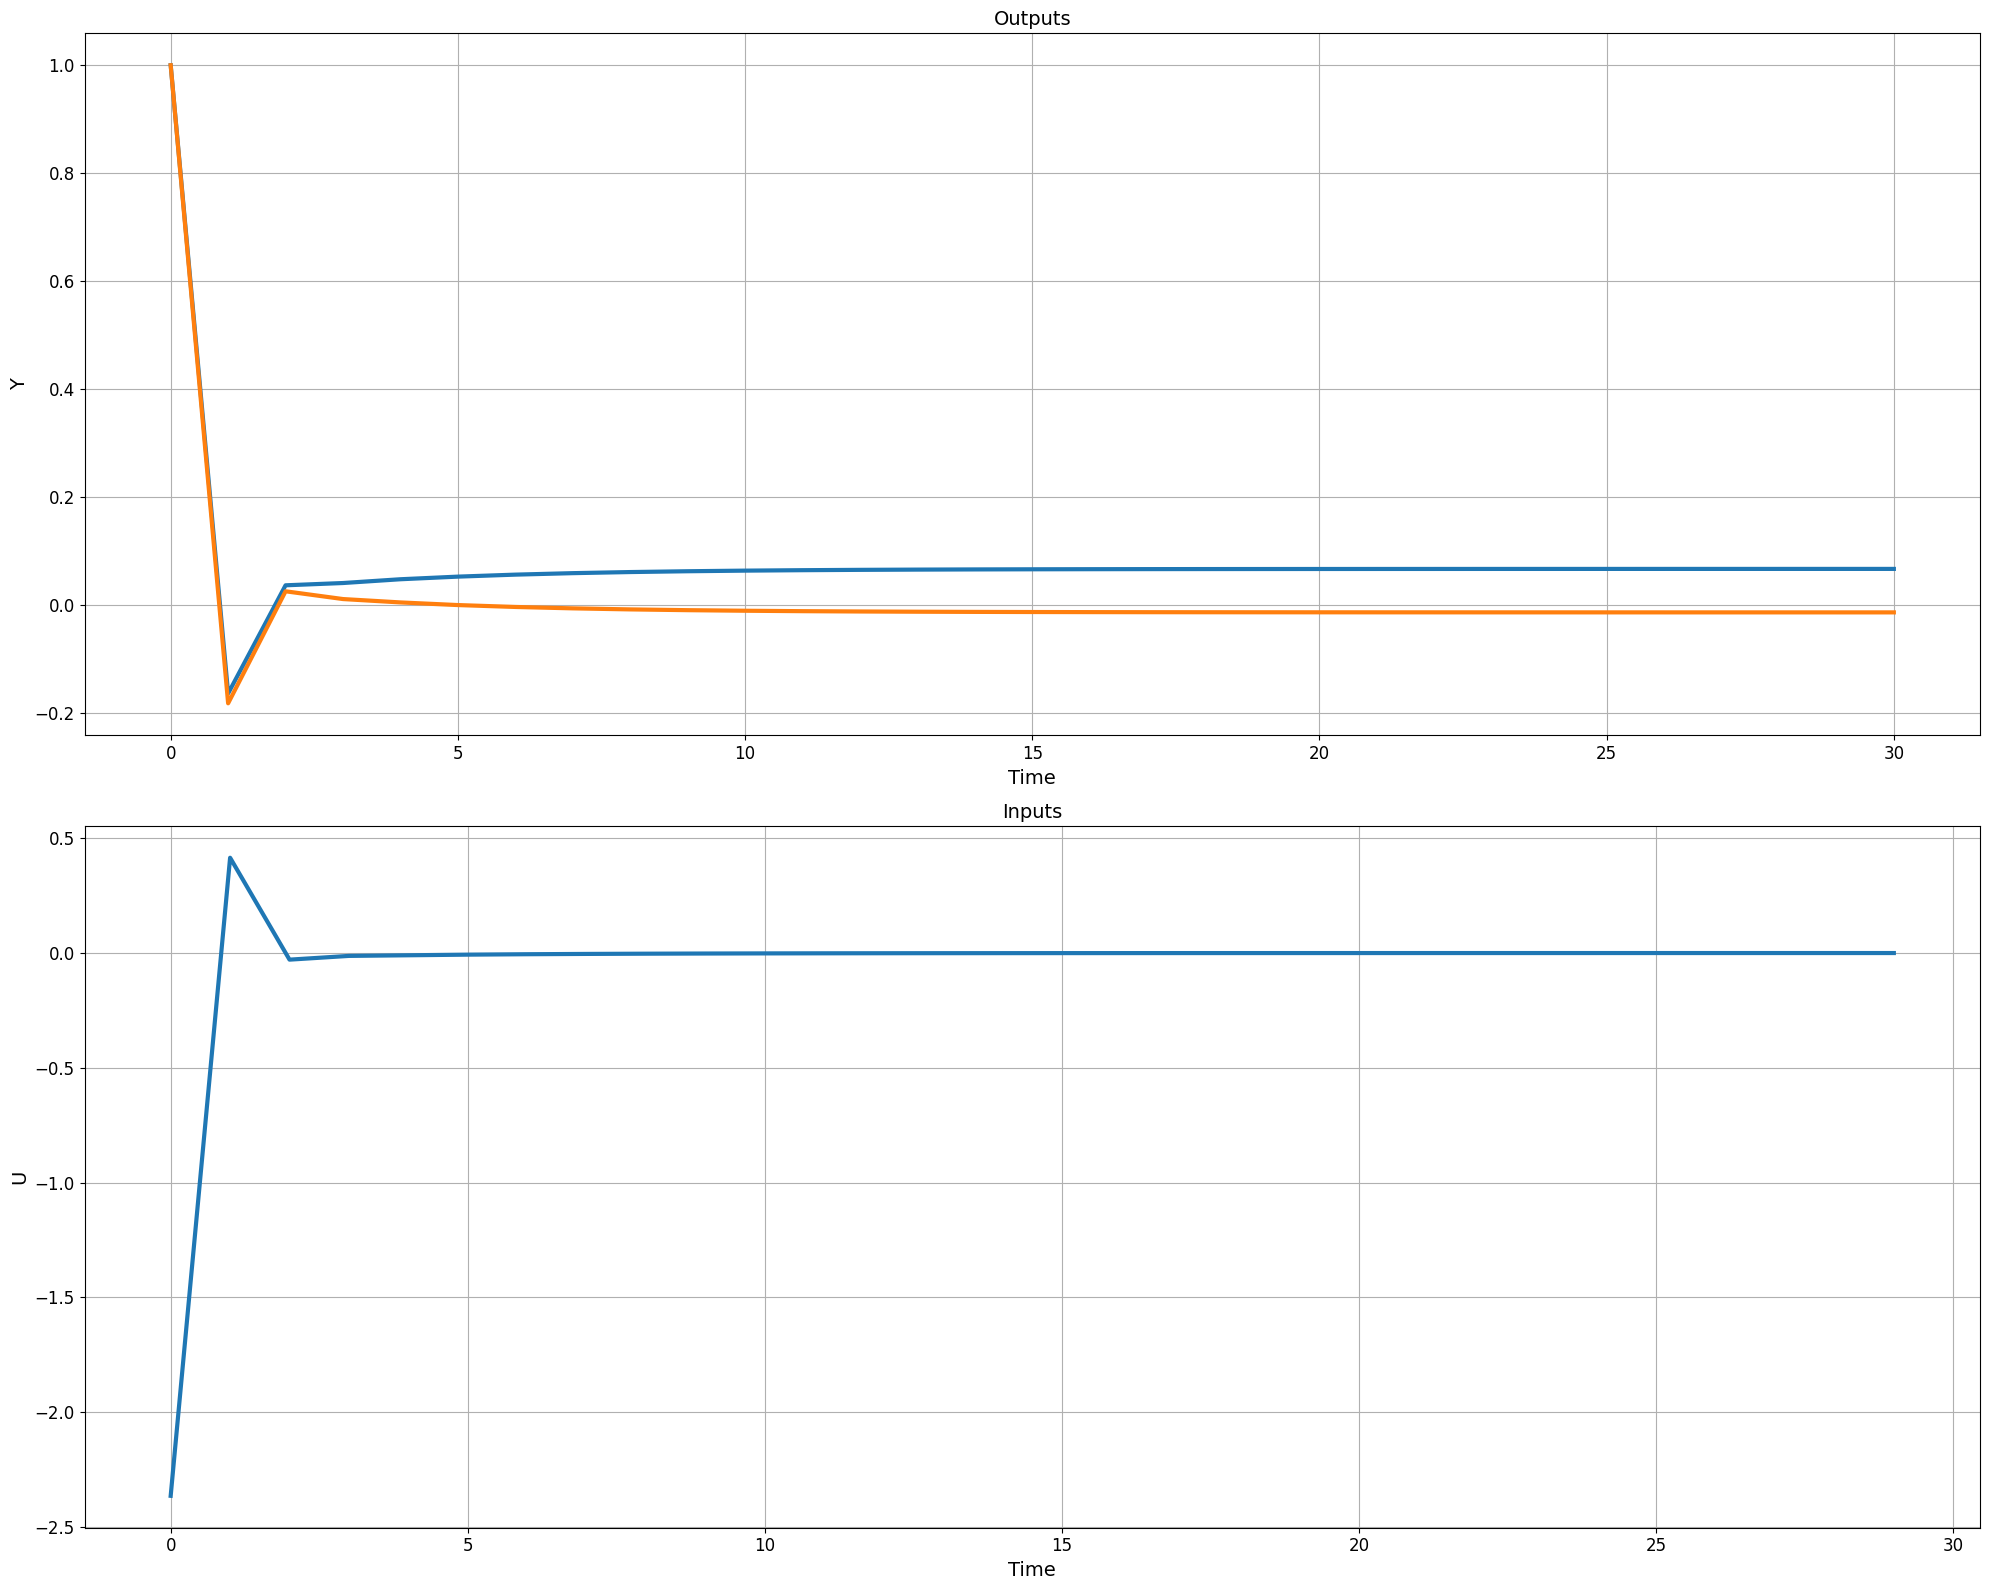

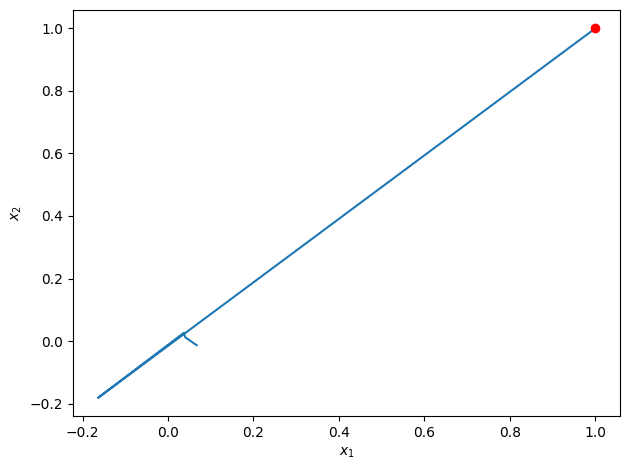

<Figure size 640x480 with 0 Axes>

In [50]:
# Test best model with prediction horizon of 50
problem.load_state_dict(best_model)
data = {'X': torch.ones(1, 1, nx, dtype=torch.float32)}
nsteps = 30
cl_system.nsteps = nsteps
trajectories = cl_system(data)
pltCL(Y=trajectories['X'].detach().reshape(nsteps+1, 2), U=trajectories['U'].detach().reshape(nsteps, 1), figname='cl.png')
pltPhase(X=trajectories['X'].detach().reshape(nsteps+1, 2), figname='phase.png')